In [197]:
import numpy as np
import matplotlib.pyplot as plt
import time

from scipy.io import arff
from sklearn import cluster
from sklearn import metrics
from sklearn.neighbors import NearestNeighbors

-------------------------------------------
Affichage données standardisées            


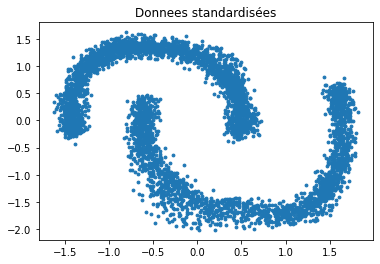

In [198]:
path = './artificial/'
databrut = arff.loadarff(open(path+"banana.arff", 'r'))
data = [[x[0],x[1]] for x in databrut[0]]
datanp = np.array([[x[0],x[1]] for x in databrut[0]])


########################################################################
# Preprocessing: standardization of data
########################################################################

from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(datanp)

data_scaled = scaler.transform(datanp)

import scipy.cluster.hierarchy as shc

print("-------------------------------------------")
print("Affichage données standardisées            ")
f0_scaled = data_scaled[:,0] # tous les élements de la première colonne
f1_scaled = data_scaled[:,1] # tous les éléments de la deuxième colonne
#print(f0)
#print(f1)

plt.scatter(f0_scaled, f1_scaled, s=8)
plt.title("Donnees standardisées")
plt.show()


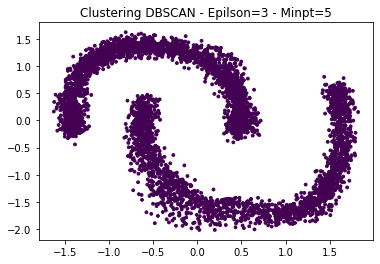

In [199]:
########################################################################
# Run DBSCAN clustering method 
# for a given number of parameters eps and min_samples
#  
distance=3
min_pts=5
cl_pred = cluster.DBSCAN(eps=distance, min_samples=min_pts).fit_predict(data)

# Plot results
plt.scatter(f0_scaled, f1_scaled, c=cl_pred, s=8)
plt.title("Clustering DBSCAN - Epilson=3 - Minpt=5")
plt.show()

In [200]:
len(databrut[0][0])

3

In [201]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(cl_pred)) - (1 if -1 in cl_pred else 0)
n_noise_ = list(cl_pred).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 1
Estimated number of noise points: 0


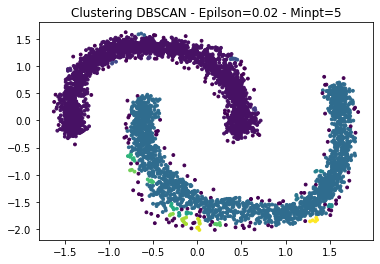

Estimated number of clusters: 23
Estimated number of noise points: 152


In [202]:
# Another example
distance=0.01
min_pts=3
cl_pred = cluster.DBSCAN(eps=distance, min_samples=min_pts).fit_predict(data)
# Plot results
plt.scatter(f0_scaled, f1_scaled, c=cl_pred, s=8)
plt.title("Clustering DBSCAN - Epilson=0.02 - Minpt=5")
plt.show()
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(cl_pred)) - (1 if -1 in cl_pred else 0)
n_noise_ = list(cl_pred).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)


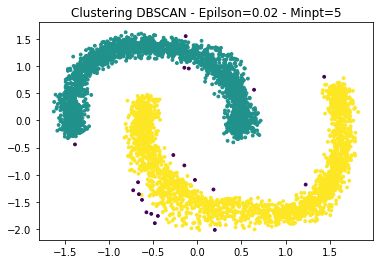

In [203]:
# Another example
distance=0.02
min_pts=5
cl_pred = cluster.DBSCAN(eps=distance, min_samples=min_pts).fit_predict(data)

# Plot results
plt.scatter(f0_scaled, f1_scaled, c=cl_pred, s=8)
plt.title("Clustering DBSCAN - Epilson=0.02 - Minpt=5")
plt.show()

In [204]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(cl_pred)) - (1 if -1 in cl_pred else 0)
n_noise_ = list(cl_pred).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)


Estimated number of clusters: 2
Estimated number of noise points: 20


In [205]:
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(data)

In [206]:
distances, indices = nbrs.kneighbors(data)

In [207]:
distances

array([[0.        , 0.        ],
       [0.        , 0.002     ],
       [0.        , 0.002     ],
       ...,
       [0.        , 0.00824621],
       [0.        , 0.00860233],
       [0.        , 0.00412311]])

In [208]:
sort_distance=np.sort(distances[:,1])

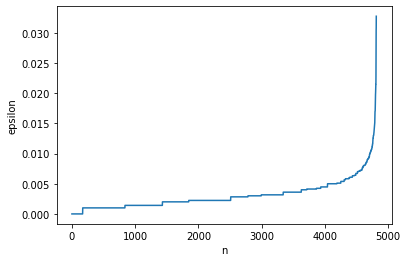

In [209]:
plt.plot(np.arange(len(sort_distance))+1, sort_distance)
plt.xlabel("n")
plt.ylabel("epsilon")
plt.show()

In [210]:
from sklearn import metrics
import time
from collections import Counter
from random import randint
from sklearn.metrics import davies_bouldin_score


#We want to determine the optimal epsilon and min_points for finding clusters
def bestConfigDBSCAN(file, params_min_pts={"n":5, "min":1, "max":8}, 
                params_eps={"n":5, "window_inf":0.75, "window_sup":1.5}):
    
    
    databrut = arff.loadarff(open(file, 'r'))
    min_points=np.arange(1, 10, 1)

    
    #With the last column is labels
    datanp = np.array([x.tolist()[0:-1] for x in databrut[0]])
    
    plt.scatter(datanp[:,0], datanp[:,1], s=8)
    plt.title("Donnees initiales")
    plt.show()
    
    #Stadardization
    scaler = preprocessing.StandardScaler().fit(datanp)
    data_scaled=scaler.transform(datanp)

    nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(data_scaled)
    distances, indices = nbrs.kneighbors(data_scaled)
    
    sort_distance=np.sort(distances[:,1])
    
    plt.plot(np.arange(len(sort_distance))+1, sort_distance)
    plt.xlabel("n")
    plt.ylabel("epsilon")
    plt.title("Fonction de répartition")
    plt.show()
    
    max_distance=sort_distance[-1]
    min_distance=sort_distance[0]
    
    print(f"Distance minimale entre un échantillon et son premier voisin : {min_distance} ")
    print(f"Distance maximale entre un échantillon et son premier voisin : {max_distance} ")

    EPS={}
    MIN_POINTS=np.linspace(params_min_pts["min"], params_min_pts["max"], params_min_pts["n"])
    #EPS=np.linspace(params_eps["window_inf"]*max_distance, params_eps['window_sup']*max_distance, params_eps["n"])
    METRICS=['euclidean', 'l1', 'l2', 'manhattan','cityblock']
    
    print(f"Paramètres 'min_pts' testés : {MIN_POINTS}")
    #print(f"Paramètres 'epsilon' testés : {EPS}")
    
    
    l=params_eps.get("n")
    m=len(MIN_POINTS)
    n=len(METRICS)
   
    
    eval_params={}
    
    eval_params['CAL']=np.zeros((l, m, n))
    eval_params['SILH']=np.zeros((l, m, n))
    eval_params['TIME']=np.zeros((l, m, n))
    eval_params['DB']=np.zeros((l, m, n))
    
    
    #Nombre de clusters
    K=np.zeros((l,m,n))
    for i_metric, v_metric in enumerate(METRICS):
        
        nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree', metric=v_metric).fit(data_scaled)
        distances, indices = nbrs.kneighbors(data_scaled)

        sort_distance=np.sort(distances[:,1])

        plt.plot(np.arange(len(sort_distance))+1, sort_distance)
        plt.xlabel("n")
        plt.ylabel("epsilon")
        plt.title(f"Fonction de répartition - metric : {v_metric}")
        plt.show()

        max_distance=sort_distance[-1]
        min_distance=sort_distance[0]

        print(f"########## METRIC - {v_metric} - ##############")
        print(f"Distance minimale entre un échantillon et son premier voisin : {min_distance} ")
        print(f"Distance maximale entre un échantillon et son premier voisin : {max_distance} ")
              
        EPS[v_metric]=np.linspace(params_eps["window_inf"]*max_distance, params_eps['window_sup']*max_distance, params_eps["n"])
        print(EPS[v_metric])
        
        
        for i_eps, v_eps in enumerate(EPS[v_metric]):
            for i_minpts, v_minpts in enumerate(MIN_POINTS):
                
                tps1 = time.time()
                cl_pred = cluster.DBSCAN(eps=v_eps, min_samples=v_minpts, metric=v_metric).fit_predict(data_scaled)
                tps2 = time.time()
                time
                n_clusters_ = len(set(cl_pred)) - (1 if -1 in cl_pred else 0)


                #If there is not enough cluster predicted
                silh=-10000
                cal=-10000
                DB=10000


                if (len(set(cl_pred))>1):
                    silh=metrics.silhouette_score(data_scaled, cl_pred)
                    cal=metrics.calinski_harabasz_score(data_scaled, cl_pred)
                    DB=davies_bouldin_score(data_scaled, cl_pred)


                t=tps2-tps1

                eval_params['SILH'][i_eps, i_minpts, i_metric]=silh
                eval_params['CAL'][i_eps, i_minpts, i_metric]=cal
                eval_params['DB'][i_eps, i_minpts, i_metric]=DB
                eval_params['TIME'][i_eps, i_minpts, i_metric]=t        


                print(f"silhouette : {silh}, calinski : {cal}, DB : {DB}, time : {t}, clusters : {n_clusters_}")
        
            
            
     #Find params that optimize metrics
    best_params={}
    best_params['CAL']=np.where(eval_params['CAL']==np.max(eval_params['CAL']))
    best_params['SILH']=np.where(eval_params['SILH']==np.max(eval_params['SILH']))
    best_params['DB']=np.where(eval_params['DB']==np.min(eval_params['DB']))
    
  
    return eval_params, best_params, EPS
            
            




    

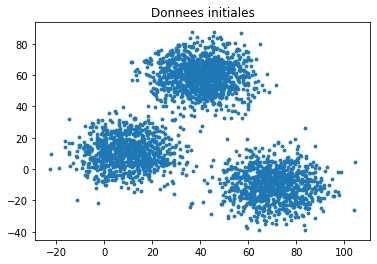

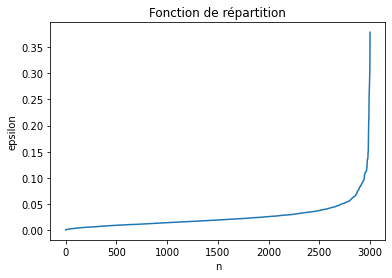

Distance minimale entre un échantillon et son premier voisin : 0.0008206797532100271 
Distance maximale entre un échantillon et son premier voisin : 0.3779551846995892 
Paramètres 'min_pts' testés : [1.   2.75 4.5  6.25 8.  ]


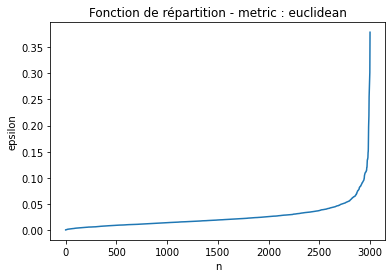

########## METRIC - euclidean - ##############
Distance minimale entre un échantillon et son premier voisin : 0.0008206797532100271 
Distance maximale entre un échantillon et son premier voisin : 0.3779551846995892 
[0.22677311 0.26456863 0.30236415 0.34015967 0.37795518]
silhouette : -0.13996033542230982, calinski : 266.90462879681235, DB : 0.6728299169603376, time : 0.01487278938293457, clusters : 15
silhouette : 0.3503672031125888, calinski : 1210.9498047138104, DB : 2.1562410720674485, time : 0.018703222274780273, clusters : 3
silhouette : 0.4791041518215288, calinski : 1811.746461833554, DB : 1.9997603502039494, time : 0.018992185592651367, clusters : 2
silhouette : 0.4791041518215288, calinski : 1811.746461833554, DB : 1.9997603502039494, time : 0.016010284423828125, clusters : 2
silhouette : 0.47652059468978286, calinski : 1811.5889926015557, DB : 1.8313781390559258, time : 0.01514434814453125, clusters : 2
silhouette : -0.34746117473610844, calinski : 2.4547381634100187, DB : 1

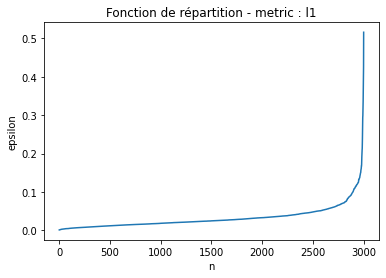

########## METRIC - l1 - ##############
Distance minimale entre un échantillon et son premier voisin : 0.0011517578674702378 
Distance maximale entre un échantillon et son premier voisin : 0.51584202742155 
[0.30950522 0.36108942 0.41267362 0.46425782 0.51584203]
silhouette : -0.4383808334640127, calinski : 2.2033849468495026, DB : 3.843176531351897, time : 0.018879175186157227, clusters : 11
silhouette : -0.009520392124667414, calinski : 2.9923390821418363, DB : 3.8677436648250683, time : 0.01846933364868164, clusters : 2
silhouette : 0.14632295531428086, calinski : 5.267540349683588, DB : 3.3279602192552122, time : 0.019646644592285156, clusters : 1
silhouette : 0.46388798519259905, calinski : 1820.8547089650092, DB : 1.6908893965140337, time : 0.017476320266723633, clusters : 2
silhouette : 0.46388798519259905, calinski : 1820.8547089650092, DB : 1.6908893965140337, time : 0.017579317092895508, clusters : 2
silhouette : -0.18040636574925178, calinski : 2.821067595958772, DB : 0.6375

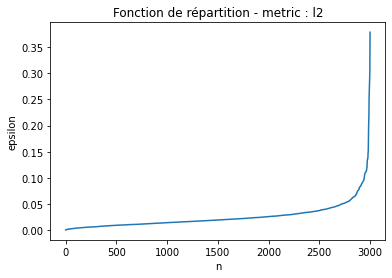

########## METRIC - l2 - ##############
Distance minimale entre un échantillon et son premier voisin : 0.0008206797532100271 
Distance maximale entre un échantillon et son premier voisin : 0.3779551846995892 
[0.22677311 0.26456863 0.30236415 0.34015967 0.37795518]
silhouette : -0.13996033542230982, calinski : 266.90462879681235, DB : 0.6728299169603376, time : 0.014432191848754883, clusters : 15
silhouette : 0.3503672031125888, calinski : 1210.9498047138104, DB : 2.1562410720674485, time : 0.017488718032836914, clusters : 3
silhouette : 0.4791041518215288, calinski : 1811.746461833554, DB : 1.9997603502039494, time : 0.013419389724731445, clusters : 2
silhouette : 0.4791041518215288, calinski : 1811.746461833554, DB : 1.9997603502039494, time : 0.02737736701965332, clusters : 2
silhouette : 0.47652059468978286, calinski : 1811.5889926015557, DB : 1.8313781390559258, time : 0.013452529907226562, clusters : 2
silhouette : -0.34746117473610844, calinski : 2.4547381634100187, DB : 1.19129

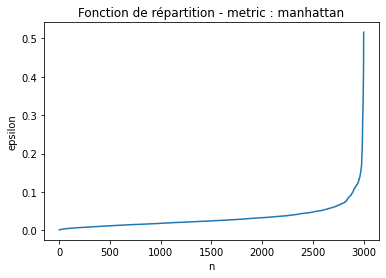

########## METRIC - manhattan - ##############
Distance minimale entre un échantillon et son premier voisin : 0.0011517578674702378 
Distance maximale entre un échantillon et son premier voisin : 0.51584202742155 
[0.30950522 0.36108942 0.41267362 0.46425782 0.51584203]
silhouette : -0.4383808334640127, calinski : 2.2033849468495026, DB : 3.843176531351897, time : 0.01805257797241211, clusters : 11
silhouette : -0.009520392124667414, calinski : 2.9923390821418363, DB : 3.8677436648250683, time : 0.021941184997558594, clusters : 2
silhouette : 0.14632295531428086, calinski : 5.267540349683588, DB : 3.3279602192552122, time : 0.021454811096191406, clusters : 1
silhouette : 0.46388798519259905, calinski : 1820.8547089650092, DB : 1.6908893965140337, time : 0.024137020111083984, clusters : 2
silhouette : 0.46388798519259905, calinski : 1820.8547089650092, DB : 1.6908893965140337, time : 0.02176380157470703, clusters : 2
silhouette : -0.18040636574925178, calinski : 2.821067595958772, DB : 

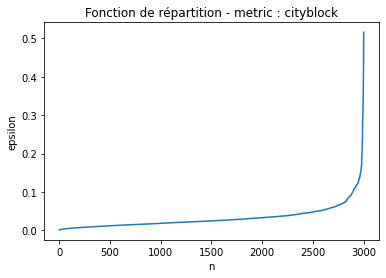

########## METRIC - cityblock - ##############
Distance minimale entre un échantillon et son premier voisin : 0.0011517578674702378 
Distance maximale entre un échantillon et son premier voisin : 0.51584202742155 
[0.30950522 0.36108942 0.41267362 0.46425782 0.51584203]
silhouette : -0.4383808334640127, calinski : 2.2033849468495026, DB : 3.843176531351897, time : 0.023949384689331055, clusters : 11
silhouette : -0.009520392124667414, calinski : 2.9923390821418363, DB : 3.8677436648250683, time : 0.020514249801635742, clusters : 2
silhouette : 0.14632295531428086, calinski : 5.267540349683588, DB : 3.3279602192552122, time : 0.024889707565307617, clusters : 1
silhouette : 0.46388798519259905, calinski : 1820.8547089650092, DB : 1.6908893965140337, time : 0.021282434463500977, clusters : 2
silhouette : 0.46388798519259905, calinski : 1820.8547089650092, DB : 1.6908893965140337, time : 0.024660587310791016, clusters : 2
silhouette : -0.18040636574925178, calinski : 2.821067595958772, DB 

In [211]:
eval_params, best_params, EPS=bestConfigDBSCAN(path+"xclara.arff", params_eps={"n":5, "window_inf":0.6, "window_sup":1})

In [212]:
best_params

{'CAL': (array([0, 0, 0, 0, 0, 0]),
  array([3, 3, 3, 4, 4, 4]),
  array([1, 3, 4, 1, 3, 4])),
 'SILH': (array([0, 0, 0, 0]), array([2, 2, 3, 3]), array([0, 2, 0, 2])),
 'DB': (array([3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4]),
  array([0, 0, 0, 1, 1, 1, 2, 2, 2, 0, 0, 1, 1]),
  array([1, 3, 4, 1, 3, 4, 1, 3, 4, 0, 2, 0, 2]))}

In [213]:
EPS

{'euclidean': array([0.22677311, 0.26456863, 0.30236415, 0.34015967, 0.37795518]),
 'l1': array([0.30950522, 0.36108942, 0.41267362, 0.46425782, 0.51584203]),
 'l2': array([0.22677311, 0.26456863, 0.30236415, 0.34015967, 0.37795518]),
 'manhattan': array([0.30950522, 0.36108942, 0.41267362, 0.46425782, 0.51584203]),
 'cityblock': array([0.30950522, 0.36108942, 0.41267362, 0.46425782, 0.51584203])}

Nous observons un grand nombre de combinaisons ayant des performances similaires selon les métriques Ue nous choisissons. Une analyse temporelle peut également être réalisée (même nécessaire pour départager les combinaisons. 
Concernant les meilleures combinaison communes (en fonction du coefficient de silhouette et de calinski, nous retrouvons (2, 0), (2, 1), etc...
C'est à dire : 
eps = 0.17793745
min_pts = 1

In [214]:
def doDBSCAN(file, eps, min_pts, metric):
    
    databrut = arff.loadarff(open(file, 'r'))
    min_points=np.arange(1, 10, 1)

    
    #With the last column is true labels
    datanp = np.array([x.tolist()[0:-1] for x in databrut[0]])
    
    #Stadardization
    scaler = preprocessing.StandardScaler().fit(datanp)
    data_scaled=scaler.transform(datanp)
    cl_pred = cluster.DBSCAN(eps=eps, min_samples=min_pts, metric=metric).fit_predict(data_scaled)
    

    # Plot results
    plt.scatter(data_scaled[:,0], data_scaled[:,1], c=cl_pred, s=8)
    plt.title(f"Clustering DBSCAN - Epilson={eps} - Minpt={min_pts} - Metric={metric}")
    plt.show()
    
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(cl_pred)) - (1 if -1 in cl_pred else 0)
    n_noise_ = list(cl_pred).count(-1)
    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    
    silh=-1000
    cal=-1000
    DB=10000
    
    if (len(set(cl_pred))>1):
        silh=metrics.silhouette_score(data_scaled, cl_pred)
        cal=metrics.calinski_harabasz_score(data_scaled, cl_pred)
        DB=davies_bouldin_score(data_scaled, cl_pred)

    
    print('coefficient de silhouette: %f' % silh)
    print('coefficient de calinsky: %f' % cal)
    print('coefficient de Davies Bouldin: %f' % DB)
    

In [215]:
best_params

{'CAL': (array([0, 0, 0, 0, 0, 0]),
  array([3, 3, 3, 4, 4, 4]),
  array([1, 3, 4, 1, 3, 4])),
 'SILH': (array([0, 0, 0, 0]), array([2, 2, 3, 3]), array([0, 2, 0, 2])),
 'DB': (array([3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4]),
  array([0, 0, 0, 1, 1, 1, 2, 2, 2, 0, 0, 1, 1]),
  array([1, 3, 4, 1, 3, 4, 1, 3, 4, 0, 2, 0, 2]))}

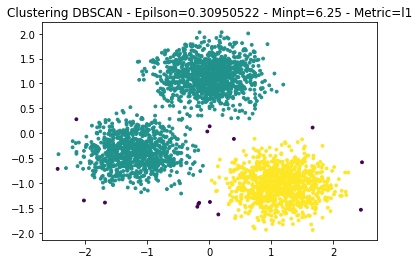

Estimated number of clusters: 2
Estimated number of noise points: 15
coefficient de silhouette: 0.463888
coefficient de calinsky: 1820.854709
coefficient de Davies Bouldin: 1.690889


In [216]:
doDBSCAN(path+"xclara.arff",0.30950522,6.25,'l1')

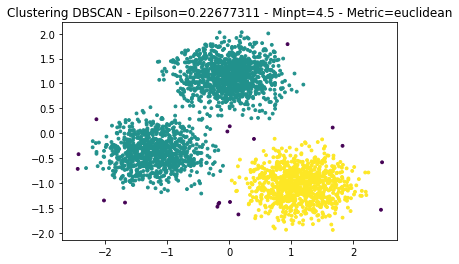

Estimated number of clusters: 2
Estimated number of noise points: 18
coefficient de silhouette: 0.479104
coefficient de calinsky: 1811.746462
coefficient de Davies Bouldin: 1.999760


In [217]:
doDBSCAN(path+"xclara.arff",0.22677311,4.5,'euclidean')

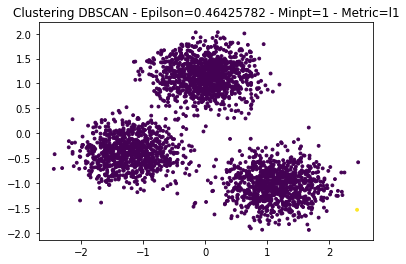

Estimated number of clusters: 2
Estimated number of noise points: 0
coefficient de silhouette: 0.302843
coefficient de calinsky: 4.183306
coefficient de Davies Bouldin: 0.471109


In [218]:
doDBSCAN(path+"xclara.arff",0.46425782,1,'l1')

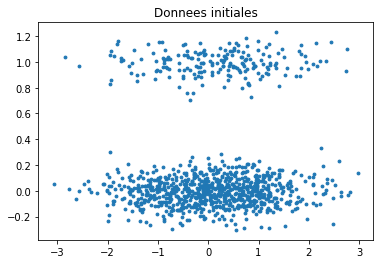

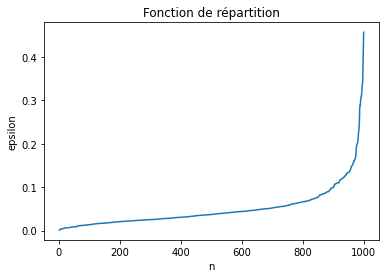

Distance minimale entre un échantillon et son premier voisin : 0.0016114348923732921 
Distance maximale entre un échantillon et son premier voisin : 0.45675539209480714 
Paramètres 'min_pts' testés : [1.   2.75 4.5  6.25 8.  ]


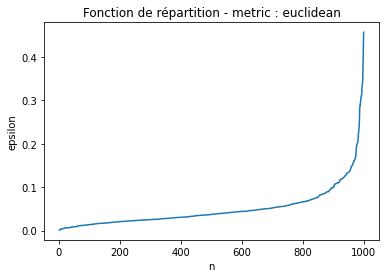

########## METRIC - euclidean - ##############
Distance minimale entre un échantillon et son premier voisin : 0.0016114348923732921 
Distance maximale entre un échantillon et son premier voisin : 0.45675539209480714 
[0.27405324 0.31972877 0.36540431 0.41107985 0.45675539]
silhouette : 0.02846125453792607, calinski : 65.212641797856, DB : 0.39894580764994075, time : 0.004257678985595703, clusters : 17
silhouette : 0.5532747147979123, calinski : 426.40942276863393, DB : 2.65852407555883, time : 0.0068378448486328125, clusters : 2
silhouette : 0.5453813314085362, calinski : 423.61130503248813, DB : 2.516927729767293, time : 0.005655527114868164, clusters : 2
silhouette : 0.3926907801924921, calinski : 240.60972163835606, DB : 1.818148018638326, time : 0.005650997161865234, clusters : 4
silhouette : 0.49549910442833034, calinski : 293.3580378997113, DB : 2.393751448130512, time : 0.005622148513793945, clusters : 3
silhouette : 0.16993002713614352, calinski : 100.07760181688674, DB : 0.413

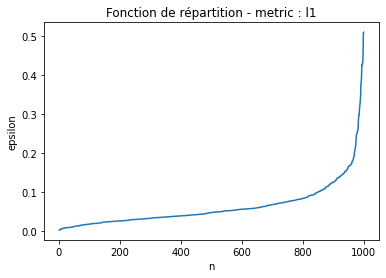

########## METRIC - l1 - ##############
Distance minimale entre un échantillon et son premier voisin : 0.0021886564213903503 
Distance maximale entre un échantillon et son premier voisin : 0.5088796182700002 
[0.30532777 0.35621573 0.40710369 0.45799166 0.50887962]
silhouette : -0.07881655977912207, calinski : 55.978911982620595, DB : 0.4437440256808408, time : 0.006322145462036133, clusters : 20
silhouette : 0.5361165673756241, calinski : 423.1518977194178, DB : 2.2722939624865837, time : 0.005944252014160156, clusters : 2
silhouette : 0.5341896288537835, calinski : 413.50836905330806, DB : 2.4657027024750207, time : 0.005934000015258789, clusters : 2
silhouette : 0.4795572814968714, calinski : 214.38551381425958, DB : 1.98179749524003, time : 0.006264448165893555, clusters : 4
silhouette : 0.4391186294559256, calinski : 211.07608012927594, DB : 2.0691306541251917, time : 0.00606226921081543, clusters : 4
silhouette : 0.16939704543129122, calinski : 84.77859911249107, DB : 0.389127549

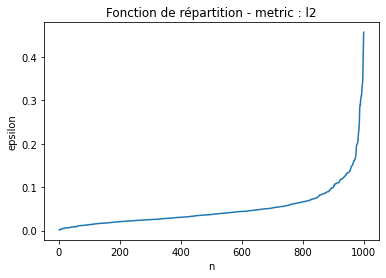

########## METRIC - l2 - ##############
Distance minimale entre un échantillon et son premier voisin : 0.0016114348923732921 
Distance maximale entre un échantillon et son premier voisin : 0.45675539209480714 
[0.27405324 0.31972877 0.36540431 0.41107985 0.45675539]
silhouette : 0.02846125453792607, calinski : 65.212641797856, DB : 0.39894580764994075, time : 0.0056035518646240234, clusters : 17
silhouette : 0.5532747147979123, calinski : 426.40942276863393, DB : 2.65852407555883, time : 0.007855653762817383, clusters : 2
silhouette : 0.5453813314085362, calinski : 423.61130503248813, DB : 2.516927729767293, time : 0.005525350570678711, clusters : 2
silhouette : 0.3926907801924921, calinski : 240.60972163835606, DB : 1.818148018638326, time : 0.0055010318756103516, clusters : 4
silhouette : 0.49549910442833034, calinski : 293.3580378997113, DB : 2.393751448130512, time : 0.005751132965087891, clusters : 3
silhouette : 0.16993002713614352, calinski : 100.07760181688674, DB : 0.413712661

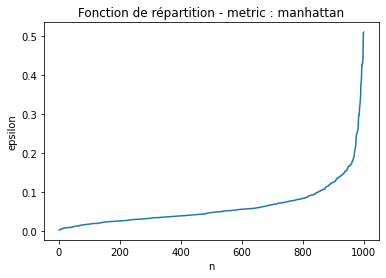

########## METRIC - manhattan - ##############
Distance minimale entre un échantillon et son premier voisin : 0.0021886564213903503 
Distance maximale entre un échantillon et son premier voisin : 0.5088796182700002 
[0.30532777 0.35621573 0.40710369 0.45799166 0.50887962]
silhouette : -0.07881655977912207, calinski : 55.978911982620595, DB : 0.4437440256808408, time : 0.007396697998046875, clusters : 20
silhouette : 0.5361165673756241, calinski : 423.1518977194178, DB : 2.2722939624865837, time : 0.00855398178100586, clusters : 2
silhouette : 0.5341896288537835, calinski : 413.50836905330806, DB : 2.4657027024750207, time : 0.008799076080322266, clusters : 2
silhouette : 0.4795572814968714, calinski : 214.38551381425958, DB : 1.98179749524003, time : 0.008310794830322266, clusters : 4
silhouette : 0.4391186294559256, calinski : 211.07608012927594, DB : 2.0691306541251917, time : 0.008348464965820312, clusters : 4
silhouette : 0.16939704543129122, calinski : 84.77859911249107, DB : 0.38

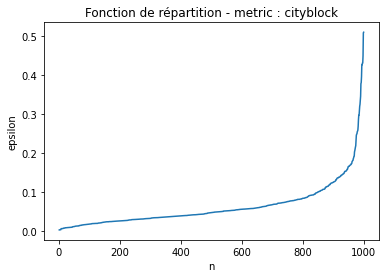

########## METRIC - cityblock - ##############
Distance minimale entre un échantillon et son premier voisin : 0.0021886564213903503 
Distance maximale entre un échantillon et son premier voisin : 0.5088796182700002 
[0.30532777 0.35621573 0.40710369 0.45799166 0.50887962]
silhouette : -0.07881655977912207, calinski : 55.978911982620595, DB : 0.4437440256808408, time : 0.006410121917724609, clusters : 20
silhouette : 0.5361165673756241, calinski : 423.1518977194178, DB : 2.2722939624865837, time : 0.008296012878417969, clusters : 2
silhouette : 0.5341896288537835, calinski : 413.50836905330806, DB : 2.4657027024750207, time : 0.008347272872924805, clusters : 2
silhouette : 0.4795572814968714, calinski : 214.38551381425958, DB : 1.98179749524003, time : 0.00834035873413086, clusters : 4
silhouette : 0.4391186294559256, calinski : 211.07608012927594, DB : 2.0691306541251917, time : 0.008304119110107422, clusters : 4
silhouette : 0.16939704543129122, calinski : 84.77859911249107, DB : 0.38

In [219]:
eval_params, best_params, EPS=bestConfigDBSCAN(path+"long3.arff", params_eps={"n":5, "window_inf":0.6, "window_sup":1})

In [220]:
best_params

{'CAL': (array([4, 4, 4, 4, 4, 4]),
  array([0, 0, 0, 1, 1, 1]),
  array([1, 3, 4, 1, 3, 4])),
 'SILH': (array([3, 3]), array([1, 1]), array([0, 2])),
 'DB': (array([1, 1, 1]), array([0, 0, 0]), array([1, 3, 4]))}

In [221]:
EPS

{'euclidean': array([0.27405324, 0.31972877, 0.36540431, 0.41107985, 0.45675539]),
 'l1': array([0.30532777, 0.35621573, 0.40710369, 0.45799166, 0.50887962]),
 'l2': array([0.27405324, 0.31972877, 0.36540431, 0.41107985, 0.45675539]),
 'manhattan': array([0.30532777, 0.35621573, 0.40710369, 0.45799166, 0.50887962]),
 'cityblock': array([0.30532777, 0.35621573, 0.40710369, 0.45799166, 0.50887962])}

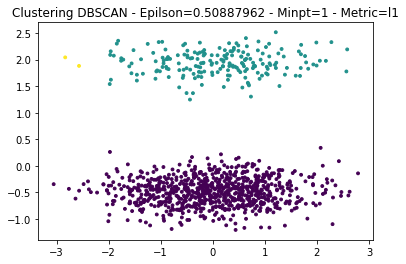

Estimated number of clusters: 3
Estimated number of noise points: 0
coefficient de silhouette: 0.534191
coefficient de calinsky: 455.765014
coefficient de Davies Bouldin: 0.586028


In [222]:
doDBSCAN(path+"long3.arff",0.50887962,1,'l1')

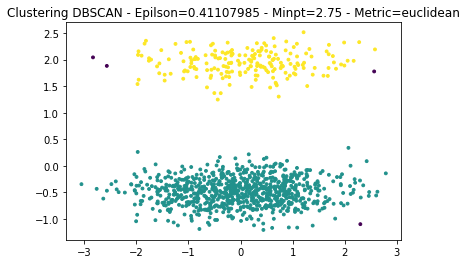

Estimated number of clusters: 2
Estimated number of noise points: 4
coefficient de silhouette: 0.563363
coefficient de calinsky: 436.689814
coefficient de Davies Bouldin: 3.761404


In [223]:
doDBSCAN(path+"long3.arff",0.41107985,2.75,'euclidean')

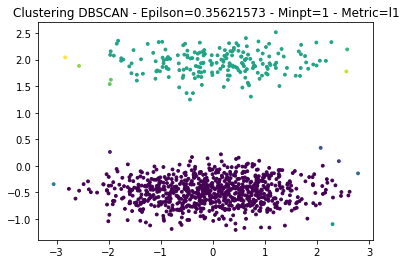

Estimated number of clusters: 13
Estimated number of noise points: 0
coefficient de silhouette: 0.169397
coefficient de calinsky: 84.778599
coefficient de Davies Bouldin: 0.389128


In [224]:
doDBSCAN(path+"long3.arff",0.35621573,1,'l1')

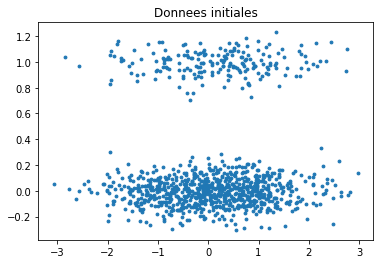

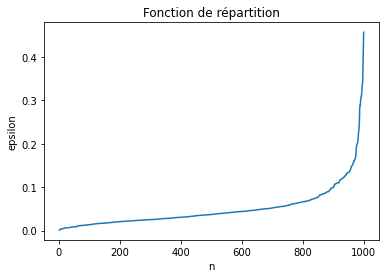

Distance minimale entre un échantillon et son premier voisin : 0.0016114348923732921 
Distance maximale entre un échantillon et son premier voisin : 0.45675539209480714 
Paramètres 'min_pts' testés : [1.   2.75 4.5  6.25 8.  ]


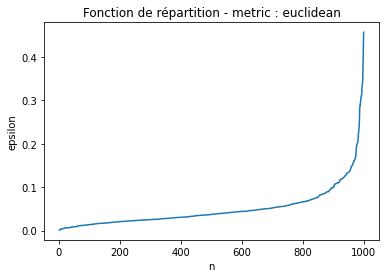

########## METRIC - euclidean - ##############
Distance minimale entre un échantillon et son premier voisin : 0.0016114348923732921 
Distance maximale entre un échantillon et son premier voisin : 0.45675539209480714 
[0.41107985 0.47959316 0.54810647 0.61661978 0.68513309]
silhouette : 0.3724599351332236, calinski : 232.8777664156909, DB : 0.488913806225474, time : 0.008385658264160156, clusters : 5
silhouette : 0.563363192123059, calinski : 436.689814122739, DB : 3.7614043335118414, time : 0.00917196273803711, clusters : 2
silhouette : 0.5605144915479057, calinski : 435.95027769188215, DB : 4.848419665137158, time : 0.009260892868041992, clusters : 2
silhouette : 0.5605144915479057, calinski : 435.95027769188215, DB : 4.848419665137158, time : 0.009453058242797852, clusters : 2
silhouette : 0.5616191658184365, calinski : 434.71091944357977, DB : 3.2036995859718047, time : 0.00976872444152832, clusters : 2
silhouette : 0.5341907012394047, calinski : 455.765013912583, DB : 0.58602794917

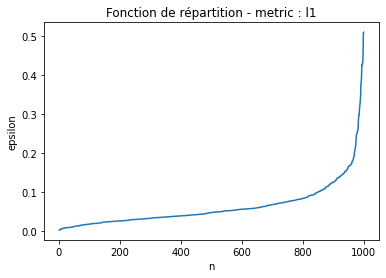

########## METRIC - l1 - ##############
Distance minimale entre un échantillon et son premier voisin : 0.0021886564213903503 
Distance maximale entre un échantillon et son premier voisin : 0.5088796182700002 
[0.45799166 0.5343236  0.61065554 0.68698748 0.76331943]
silhouette : 0.3512883421189402, calinski : 190.2649615036692, DB : 0.46629966425791874, time : 0.008306503295898438, clusters : 6
silhouette : 0.5571611290436151, calinski : 439.81885105779116, DB : 2.371660060061094, time : 0.012043952941894531, clusters : 2
silhouette : 0.5607292829946219, calinski : 434.8272990947132, DB : 3.946974279868275, time : 0.011757373809814453, clusters : 2
silhouette : 0.560924333863053, calinski : 431.155720591454, DB : 3.811213615059138, time : 0.011619329452514648, clusters : 2
silhouette : 0.560924333863053, calinski : 431.155720591454, DB : 3.811213615059138, time : 0.011883258819580078, clusters : 2
silhouette : 0.5341907012394047, calinski : 455.765013912583, DB : 0.5860279491737457, tim

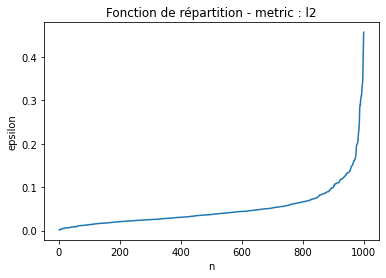

########## METRIC - l2 - ##############
Distance minimale entre un échantillon et son premier voisin : 0.0016114348923732921 
Distance maximale entre un échantillon et son premier voisin : 0.45675539209480714 
[0.41107985 0.47959316 0.54810647 0.61661978 0.68513309]
silhouette : 0.3724599351332236, calinski : 232.8777664156909, DB : 0.488913806225474, time : 0.0076656341552734375, clusters : 5
silhouette : 0.563363192123059, calinski : 436.689814122739, DB : 3.7614043335118414, time : 0.010550975799560547, clusters : 2
silhouette : 0.5605144915479057, calinski : 435.95027769188215, DB : 4.848419665137158, time : 0.010565757751464844, clusters : 2
silhouette : 0.5605144915479057, calinski : 435.95027769188215, DB : 4.848419665137158, time : 0.010755062103271484, clusters : 2
silhouette : 0.5616191658184365, calinski : 434.71091944357977, DB : 3.2036995859718047, time : 0.010717630386352539, clusters : 2
silhouette : 0.5341907012394047, calinski : 455.765013912583, DB : 0.586027949173745

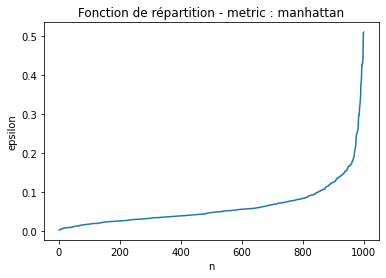

########## METRIC - manhattan - ##############
Distance minimale entre un échantillon et son premier voisin : 0.0021886564213903503 
Distance maximale entre un échantillon et son premier voisin : 0.5088796182700002 
[0.45799166 0.5343236  0.61065554 0.68698748 0.76331943]
silhouette : 0.3512883421189402, calinski : 190.2649615036692, DB : 0.46629966425791874, time : 0.008089542388916016, clusters : 6
silhouette : 0.5571611290436151, calinski : 439.81885105779116, DB : 2.371660060061094, time : 0.011182308197021484, clusters : 2
silhouette : 0.5607292829946219, calinski : 434.8272990947132, DB : 3.946974279868275, time : 0.011241436004638672, clusters : 2
silhouette : 0.560924333863053, calinski : 431.155720591454, DB : 3.811213615059138, time : 0.011214494705200195, clusters : 2
silhouette : 0.560924333863053, calinski : 431.155720591454, DB : 3.811213615059138, time : 0.01121830940246582, clusters : 2
silhouette : 0.5341907012394047, calinski : 455.765013912583, DB : 0.586027949173745

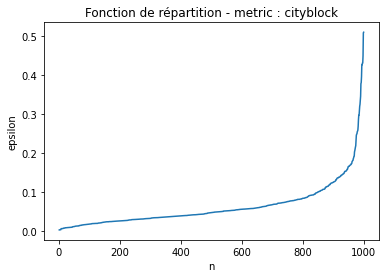

########## METRIC - cityblock - ##############
Distance minimale entre un échantillon et son premier voisin : 0.0021886564213903503 
Distance maximale entre un échantillon et son premier voisin : 0.5088796182700002 
[0.45799166 0.5343236  0.61065554 0.68698748 0.76331943]
silhouette : 0.3512883421189402, calinski : 190.2649615036692, DB : 0.46629966425791874, time : 0.010177135467529297, clusters : 6
silhouette : 0.5571611290436151, calinski : 439.81885105779116, DB : 2.371660060061094, time : 0.011541366577148438, clusters : 2
silhouette : 0.5607292829946219, calinski : 434.8272990947132, DB : 3.946974279868275, time : 0.011171340942382812, clusters : 2
silhouette : 0.560924333863053, calinski : 431.155720591454, DB : 3.811213615059138, time : 0.011481523513793945, clusters : 2
silhouette : 0.560924333863053, calinski : 431.155720591454, DB : 3.811213615059138, time : 0.011139392852783203, clusters : 2
silhouette : 0.5341907012394047, calinski : 455.765013912583, DB : 0.58602794917374

In [225]:
#Moving epsilon to highest values
eval_params, best_params, EPS=bestConfigDBSCAN(path+"long3.arff", params_eps={"n":5, "window_inf":0.9, "window_sup":1.5})

In [226]:
best_params

{'CAL': (array([4, 4, 4, 4, 4, 4]),
  array([0, 0, 1, 1, 2, 2]),
  array([0, 2, 0, 2, 0, 2])),
 'SILH': (array([4, 4, 4, 4, 4, 4]),
  array([0, 0, 1, 1, 2, 2]),
  array([0, 2, 0, 2, 0, 2])),
 'DB': (array([0, 0, 0]), array([0, 0, 0]), array([1, 3, 4]))}

In [227]:
EPS

{'euclidean': array([0.41107985, 0.47959316, 0.54810647, 0.61661978, 0.68513309]),
 'l1': array([0.45799166, 0.5343236 , 0.61065554, 0.68698748, 0.76331943]),
 'l2': array([0.41107985, 0.47959316, 0.54810647, 0.61661978, 0.68513309]),
 'manhattan': array([0.45799166, 0.5343236 , 0.61065554, 0.68698748, 0.76331943]),
 'cityblock': array([0.45799166, 0.5343236 , 0.61065554, 0.68698748, 0.76331943])}

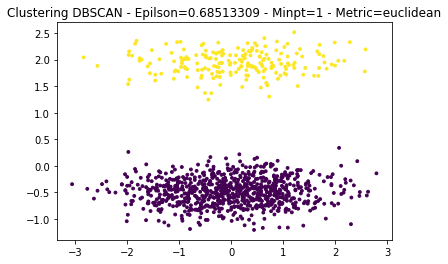

Estimated number of clusters: 2
Estimated number of noise points: 0
coefficient de silhouette: 0.566700
coefficient de calinsky: 884.141676
coefficient de Davies Bouldin: 0.711187


In [228]:
doDBSCAN(path+"long3.arff",0.68513309,1,'euclidean')

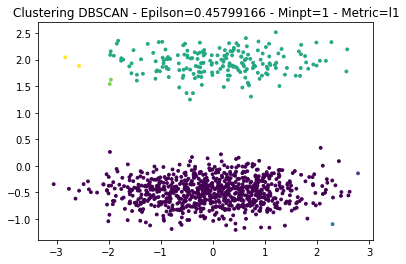

Estimated number of clusters: 6
Estimated number of noise points: 0
coefficient de silhouette: 0.351288
coefficient de calinsky: 190.264962
coefficient de Davies Bouldin: 0.466300


In [229]:
doDBSCAN(path+"long3.arff",0.45799166,1,'l1')

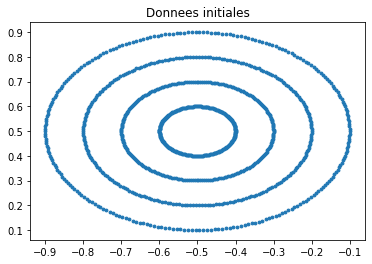

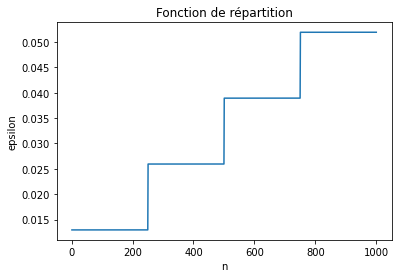

Distance minimale entre un échantillon et son premier voisin : 0.012974562315813301 
Distance maximale entre un échantillon et son premier voisin : 0.05191389432071155 
Paramètres 'min_pts' testés : [1.   2.75 4.5  6.25 8.  ]


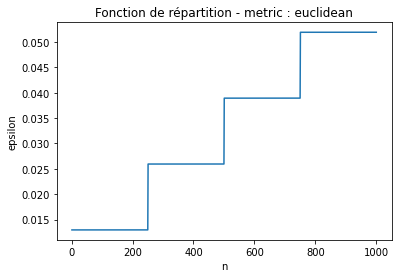

########## METRIC - euclidean - ##############
Distance minimale entre un échantillon et son premier voisin : 0.012974562315813301 
Distance maximale entre un échantillon et son premier voisin : 0.05191389432071155 
[0.0467225  0.05450959 0.06229667 0.07008376 0.07787084]
silhouette : -0.13948899039493431, calinski : 3.3877570119690157, DB : 109941532153841.4, time : 0.0042154788970947266, clusters : 253
silhouette : -0.04257841913156522, calinski : 3.1077590583071237e-30, DB : 0.0, time : 0.004344463348388672, clusters : 3
silhouette : -0.0313374692744095, calinski : 9.676016700359315e-31, DB : 0.0, time : 0.004102230072021484, clusters : 1
silhouette : -0.0313374692744095, calinski : 9.676016700359315e-31, DB : 0.0, time : 0.004715919494628906, clusters : 1
silhouette : -10000, calinski : -10000, DB : 10000, time : 0.005755186080932617, clusters : 0
silhouette : -0.04257841913156522, calinski : 3.1077590583071237e-30, DB : 0.0, time : 0.00440669059753418, clusters : 4
silhouette : -0

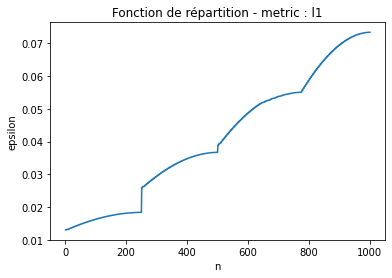

########## METRIC - l1 - ##############
Distance minimale entre un échantillon et son premier voisin : 0.01298223889130088 
Distance maximale entre un échantillon et son premier voisin : 0.07340077850530924 
[0.0660607  0.07707082 0.08808093 0.09909105 0.11010117]
silhouette : -0.1529383692956089, calinski : 6.435298912070927, DB : 189219099557291.12, time : 0.005092620849609375, clusters : 147
silhouette : -0.06842687784437092, calinski : 41.25519895929033, DB : 7461842428218472.0, time : 0.005100727081298828, clusters : 7
silhouette : -0.30130980320591433, calinski : 12.295309995135083, DB : 5804632621554500.0, time : 0.004953145980834961, clusters : 5
silhouette : -0.0313374692744095, calinski : 9.676016700359315e-31, DB : 0.0, time : 0.004954814910888672, clusters : 1
silhouette : -0.3144123938408059, calinski : 4.5955661576199995, DB : 3.0942553803949657, time : 0.005045890808105469, clusters : 4
silhouette : -0.04257841913156522, calinski : 3.1077590583071237e-30, DB : 0.0, time 

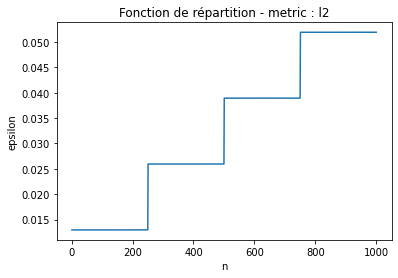

########## METRIC - l2 - ##############
Distance minimale entre un échantillon et son premier voisin : 0.012974562315813301 
Distance maximale entre un échantillon et son premier voisin : 0.05191389432071155 
[0.0467225  0.05450959 0.06229667 0.07008376 0.07787084]
silhouette : -0.13948899039493431, calinski : 3.3877570119690157, DB : 109941532153841.4, time : 0.003500223159790039, clusters : 253
silhouette : -0.04257841913156522, calinski : 3.1077590583071237e-30, DB : 0.0, time : 0.004758119583129883, clusters : 3
silhouette : -0.0313374692744095, calinski : 9.676016700359315e-31, DB : 0.0, time : 0.004651308059692383, clusters : 1
silhouette : -0.0313374692744095, calinski : 9.676016700359315e-31, DB : 0.0, time : 0.004658699035644531, clusters : 1
silhouette : -10000, calinski : -10000, DB : 10000, time : 0.0045702457427978516, clusters : 0
silhouette : -0.04257841913156522, calinski : 3.1077590583071237e-30, DB : 0.0, time : 0.0047228336334228516, clusters : 4
silhouette : -0.0425

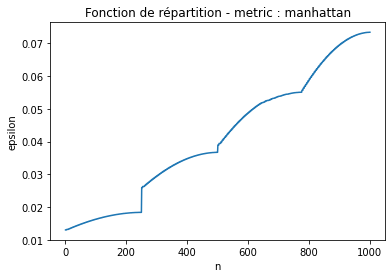

########## METRIC - manhattan - ##############
Distance minimale entre un échantillon et son premier voisin : 0.01298223889130088 
Distance maximale entre un échantillon et son premier voisin : 0.07340077850530924 
[0.0660607  0.07707082 0.08808093 0.09909105 0.11010117]
silhouette : -0.1529383692956089, calinski : 6.435298912070927, DB : 189219099557291.12, time : 0.003614664077758789, clusters : 147
silhouette : -0.06842687784437092, calinski : 41.25519895929033, DB : 7461842428218472.0, time : 0.004917621612548828, clusters : 7
silhouette : -0.30130980320591433, calinski : 12.295309995135083, DB : 5804632621554500.0, time : 0.00502777099609375, clusters : 5
silhouette : -0.0313374692744095, calinski : 9.676016700359315e-31, DB : 0.0, time : 0.004967451095581055, clusters : 1
silhouette : -0.3144123938408059, calinski : 4.5955661576199995, DB : 3.0942553803949657, time : 0.004938364028930664, clusters : 4
silhouette : -0.04257841913156522, calinski : 3.1077590583071237e-30, DB : 0.0,

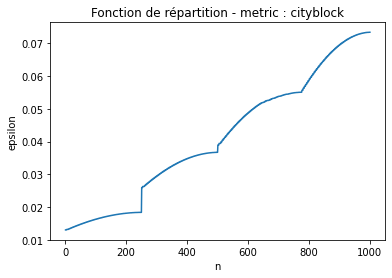

########## METRIC - cityblock - ##############
Distance minimale entre un échantillon et son premier voisin : 0.01298223889130088 
Distance maximale entre un échantillon et son premier voisin : 0.07340077850530924 
[0.0660607  0.07707082 0.08808093 0.09909105 0.11010117]
silhouette : -0.1529383692956089, calinski : 6.435298912070927, DB : 189219099557291.12, time : 0.0034847259521484375, clusters : 147
silhouette : -0.06842687784437092, calinski : 41.25519895929033, DB : 7461842428218472.0, time : 0.005139827728271484, clusters : 7
silhouette : -0.30130980320591433, calinski : 12.295309995135083, DB : 5804632621554500.0, time : 0.005040168762207031, clusters : 5
silhouette : -0.0313374692744095, calinski : 9.676016700359315e-31, DB : 0.0, time : 0.0048906803131103516, clusters : 1
silhouette : -0.3144123938408059, calinski : 4.5955661576199995, DB : 3.0942553803949657, time : 0.005030632019042969, clusters : 4
silhouette : -0.04257841913156522, calinski : 3.1077590583071237e-30, DB : 0

In [230]:
eval_params, best_params, EPS=bestConfigDBSCAN(path+"dartboard1.arff", params_eps={"n":5, "window_inf":0.9, "window_sup":1.5})

In [231]:
best_params

{'CAL': (array([0, 0, 0]), array([1, 1, 1]), array([1, 3, 4])),
 'SILH': (array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
         2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4]),
  array([2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 3, 3, 4, 4, 4,
         4, 4, 3, 3, 4, 4, 4, 4, 4, 4, 4]),
  array([0, 2, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 2, 0, 1, 2,
         3, 4, 0, 2, 0, 1, 2, 3, 4, 0, 2])),
 'DB': (array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
         4, 4, 4]),
  array([1, 1, 2, 2, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2,
         2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
         2, 2, 3, 3, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 3,
         3, 4, 4, 4

In [232]:
EPS

{'euclidean': array([0.0467225 , 0.05450959, 0.06229667, 0.07008376, 0.07787084]),
 'l1': array([0.0660607 , 0.07707082, 0.08808093, 0.09909105, 0.11010117]),
 'l2': array([0.0467225 , 0.05450959, 0.06229667, 0.07008376, 0.07787084]),
 'manhattan': array([0.0660607 , 0.07707082, 0.08808093, 0.09909105, 0.11010117]),
 'cityblock': array([0.0660607 , 0.07707082, 0.08808093, 0.09909105, 0.11010117])}

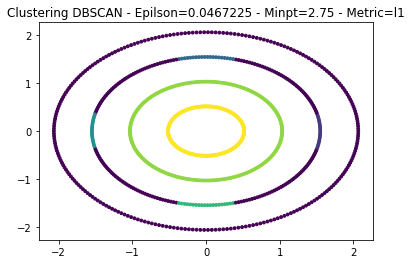

Estimated number of clusters: 6
Estimated number of noise points: 422
coefficient de silhouette: -0.214196
coefficient de calinsky: 16.717082
coefficient de Davies Bouldin: 6714646555439562.000000


In [233]:
doDBSCAN(path+"dartboard1.arff",0.0467225,2.75,'l1')

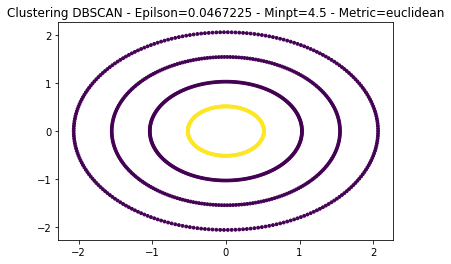

Estimated number of clusters: 1
Estimated number of noise points: 750
coefficient de silhouette: -0.031337
coefficient de calinsky: 0.000000
coefficient de Davies Bouldin: 0.000000


In [234]:
doDBSCAN(path+"dartboard1.arff",0.0467225,4.5,'euclidean')

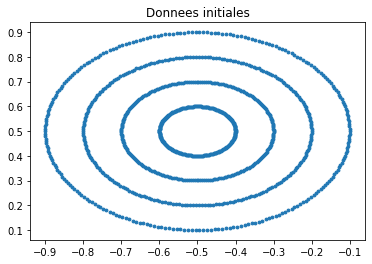

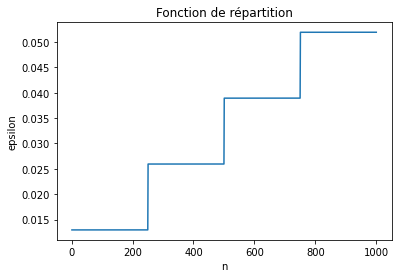

Distance minimale entre un échantillon et son premier voisin : 0.012974562315813301 
Distance maximale entre un échantillon et son premier voisin : 0.05191389432071155 
Paramètres 'min_pts' testés : [1.   2.75 4.5  6.25 8.  ]


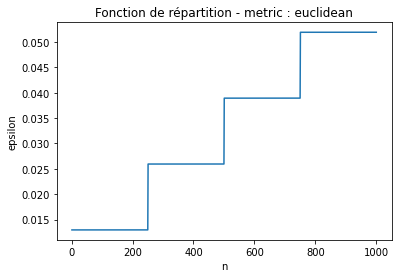

########## METRIC - euclidean - ##############
Distance minimale entre un échantillon et son premier voisin : 0.012974562315813301 
Distance maximale entre un échantillon et son premier voisin : 0.05191389432071155 
[0.04153112 0.043756   0.04598088 0.04820576 0.05043064 0.05265552
 0.0548804  0.05710528]
silhouette : -0.13948899039493431, calinski : 3.3877570119690157, DB : 109941532153841.4, time : 0.002722501754760742, clusters : 253
silhouette : -0.04257841913156522, calinski : 3.1077590583071237e-30, DB : 0.0, time : 0.004052400588989258, clusters : 3
silhouette : -0.0313374692744095, calinski : 9.676016700359315e-31, DB : 0.0, time : 0.004243135452270508, clusters : 1
silhouette : -0.0313374692744095, calinski : 9.676016700359315e-31, DB : 0.0, time : 0.004090309143066406, clusters : 1
silhouette : -10000, calinski : -10000, DB : 10000, time : 0.004047393798828125, clusters : 0
silhouette : -0.13948899039493431, calinski : 3.3877570119690157, DB : 109941532153841.4, time : 0.0041

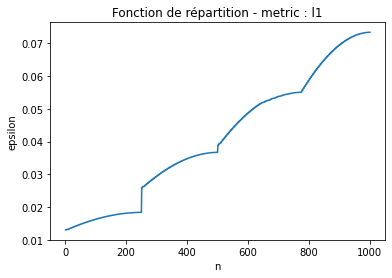

########## METRIC - l1 - ##############
Distance minimale entre un échantillon et son premier voisin : 0.01298223889130088 
Distance maximale entre un échantillon et son premier voisin : 0.07340077850530924 
[0.05872062 0.06186637 0.06501212 0.06815787 0.07130361 0.07444936
 0.07759511 0.08074086]
silhouette : -0.14668217143520662, calinski : 4.384044847106149, DB : 134372983743583.78, time : 0.003612041473388672, clusters : 207
silhouette : -0.16202517836236432, calinski : 16.766243685140594, DB : 1.042400367742021e+16, time : 0.005441904067993164, clusters : 7
silhouette : -0.3969510358956857, calinski : 5.8373036324358845, DB : 5039803288175813.0, time : 0.004878520965576172, clusters : 5
silhouette : -0.0313374692744095, calinski : 9.676016700359315e-31, DB : 0.0, time : 0.004870891571044922, clusters : 1
silhouette : -0.40010076494535335, calinski : 2.815141597652784, DB : 2.8112477894168117, time : 0.004841327667236328, clusters : 4
silhouette : -0.15007233556909752, calinski : 5

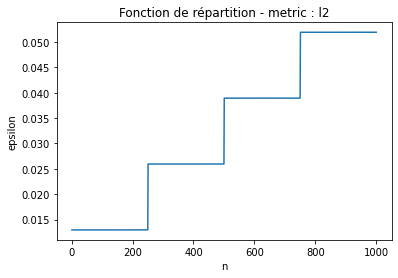

########## METRIC - l2 - ##############
Distance minimale entre un échantillon et son premier voisin : 0.012974562315813301 
Distance maximale entre un échantillon et son premier voisin : 0.05191389432071155 
[0.04153112 0.043756   0.04598088 0.04820576 0.05043064 0.05265552
 0.0548804  0.05710528]
silhouette : -0.13948899039493431, calinski : 3.3877570119690157, DB : 109941532153841.4, time : 0.0032889842987060547, clusters : 253
silhouette : -0.04257841913156522, calinski : 3.1077590583071237e-30, DB : 0.0, time : 0.004721164703369141, clusters : 3
silhouette : -0.0313374692744095, calinski : 9.676016700359315e-31, DB : 0.0, time : 0.004614591598510742, clusters : 1
silhouette : -0.0313374692744095, calinski : 9.676016700359315e-31, DB : 0.0, time : 0.004610538482666016, clusters : 1
silhouette : -10000, calinski : -10000, DB : 10000, time : 0.004483222961425781, clusters : 0
silhouette : -0.13948899039493431, calinski : 3.3877570119690157, DB : 109941532153841.4, time : 0.0045740604

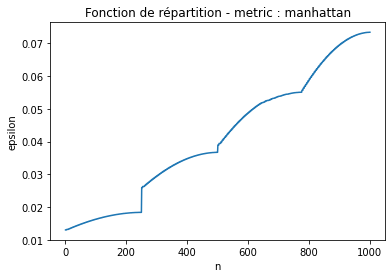

########## METRIC - manhattan - ##############
Distance minimale entre un échantillon et son premier voisin : 0.01298223889130088 
Distance maximale entre un échantillon et son premier voisin : 0.07340077850530924 
[0.05872062 0.06186637 0.06501212 0.06815787 0.07130361 0.07444936
 0.07759511 0.08074086]
silhouette : -0.14668217143520662, calinski : 4.384044847106149, DB : 134372983743583.78, time : 0.0034084320068359375, clusters : 207
silhouette : -0.16202517836236432, calinski : 16.766243685140594, DB : 1.042400367742021e+16, time : 0.005106210708618164, clusters : 7
silhouette : -0.3969510358956857, calinski : 5.8373036324358845, DB : 5039803288175813.0, time : 0.005697488784790039, clusters : 5
silhouette : -0.0313374692744095, calinski : 9.676016700359315e-31, DB : 0.0, time : 0.0048825740814208984, clusters : 1
silhouette : -0.40010076494535335, calinski : 2.815141597652784, DB : 2.8112477894168117, time : 0.004816770553588867, clusters : 4
silhouette : -0.15007233556909752, cal

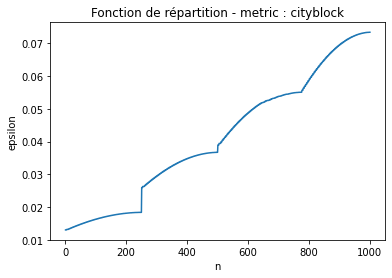

########## METRIC - cityblock - ##############
Distance minimale entre un échantillon et son premier voisin : 0.01298223889130088 
Distance maximale entre un échantillon et son premier voisin : 0.07340077850530924 
[0.05872062 0.06186637 0.06501212 0.06815787 0.07130361 0.07444936
 0.07759511 0.08074086]
silhouette : -0.14668217143520662, calinski : 4.384044847106149, DB : 134372983743583.78, time : 0.0033750534057617188, clusters : 207
silhouette : -0.16202517836236432, calinski : 16.766243685140594, DB : 1.042400367742021e+16, time : 0.005327701568603516, clusters : 7
silhouette : -0.3969510358956857, calinski : 5.8373036324358845, DB : 5039803288175813.0, time : 0.005125761032104492, clusters : 5
silhouette : -0.0313374692744095, calinski : 9.676016700359315e-31, DB : 0.0, time : 0.004889965057373047, clusters : 1
silhouette : -0.40010076494535335, calinski : 2.815141597652784, DB : 2.8112477894168117, time : 0.004790544509887695, clusters : 4
silhouette : -0.15007233556909752, cali

In [235]:
#Precising the epsilon window
eval_params, best_params, EPS=bestConfigDBSCAN(path+"dartboard1.arff", params_eps={"n":8, "window_inf":0.8, "window_sup":1.1})

In [236]:
best_params

{'CAL': (array([4, 4, 4]), array([1, 1, 1]), array([1, 3, 4])),
 'SILH': (array([4, 4, 4]), array([1, 1, 1]), array([1, 3, 4])),
 'DB': (array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
         4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
         5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
         6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
         7, 7, 7, 7]),
  array([1, 1, 2, 2, 3, 3, 3, 3, 3, 1, 1, 2, 2, 3, 3, 3, 3, 3, 1, 1, 2, 2,
         3, 3, 3, 3, 3, 1, 1, 2, 2, 3, 3, 3, 3, 3, 1, 1, 2, 2, 3, 3, 3, 3,
         3, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4,
         4, 4, 4, 4, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3,
         3, 3, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 3, 3, 4,
         4, 4, 4, 4]),
  array([0, 2, 0, 2, 0, 1, 2, 3, 4, 0, 2, 0, 2, 0, 1, 2, 3, 4, 0, 2, 

In [237]:
EPS

{'euclidean': array([0.04153112, 0.043756  , 0.04598088, 0.04820576, 0.05043064,
        0.05265552, 0.0548804 , 0.05710528]),
 'l1': array([0.05872062, 0.06186637, 0.06501212, 0.06815787, 0.07130361,
        0.07444936, 0.07759511, 0.08074086]),
 'l2': array([0.04153112, 0.043756  , 0.04598088, 0.04820576, 0.05043064,
        0.05265552, 0.0548804 , 0.05710528]),
 'manhattan': array([0.05872062, 0.06186637, 0.06501212, 0.06815787, 0.07130361,
        0.07444936, 0.07759511, 0.08074086]),
 'cityblock': array([0.05872062, 0.06186637, 0.06501212, 0.06815787, 0.07130361,
        0.07444936, 0.07759511, 0.08074086])}

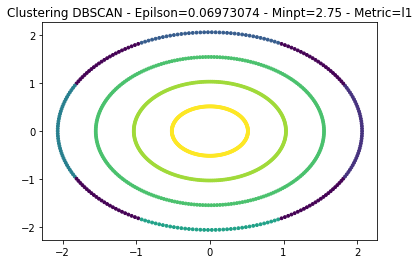

Estimated number of clusters: 7
Estimated number of noise points: 96
coefficient de silhouette: -0.013084
coefficient de calinsky: 61.807995
coefficient de Davies Bouldin: 14524333385375696.000000


In [238]:
doDBSCAN(path+"dartboard1.arff",0.06973074,2.75,'l1')

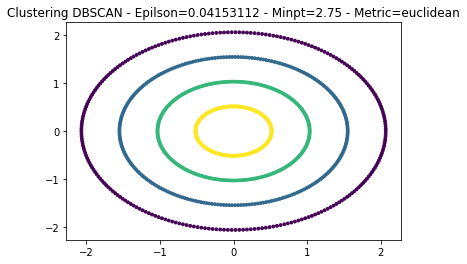

Estimated number of clusters: 3
Estimated number of noise points: 250
coefficient de silhouette: -0.042578
coefficient de calinsky: 0.000000
coefficient de Davies Bouldin: 0.000000


In [239]:
#One config with DB=0
doDBSCAN(path+"dartboard1.arff",0.04153112,2.75,'euclidean')

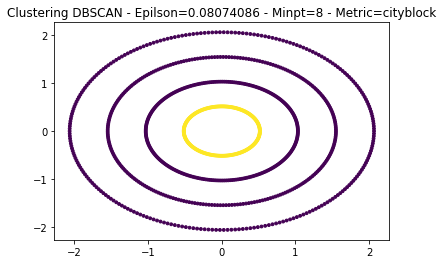

Estimated number of clusters: 1
Estimated number of noise points: 750
coefficient de silhouette: -0.031337
coefficient de calinsky: 0.000000
coefficient de Davies Bouldin: 0.000000


In [240]:
#Another one
doDBSCAN(path+"dartboard1.arff",0.08074086,8,'cityblock')

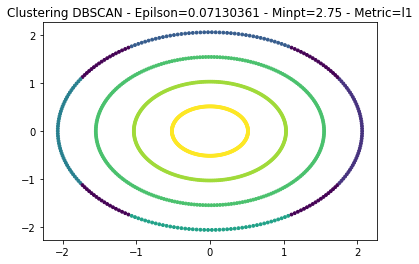

Estimated number of clusters: 7
Estimated number of noise points: 72
coefficient de silhouette: 0.011828
coefficient de calinsky: 73.581884
coefficient de Davies Bouldin: 7606384867585832.000000


In [241]:
doDBSCAN(path+"dartboard1.arff",0.07130361,2.75,'l1')

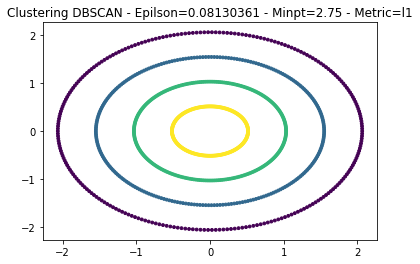

Estimated number of clusters: 4
Estimated number of noise points: 0
coefficient de silhouette: -0.042578
coefficient de calinsky: 0.000000
coefficient de Davies Bouldin: 0.000000


In [242]:
doDBSCAN(path+"dartboard1.arff",0.08130361,2.75,'l1')

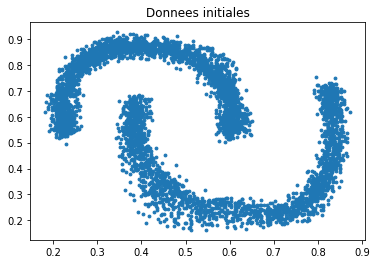

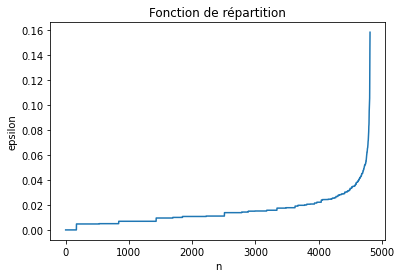

Distance minimale entre un échantillon et son premier voisin : 0.0 
Distance maximale entre un échantillon et son premier voisin : 0.15816661875132032 
Paramètres 'min_pts' testés : [1.   2.75 4.5  6.25 8.  ]


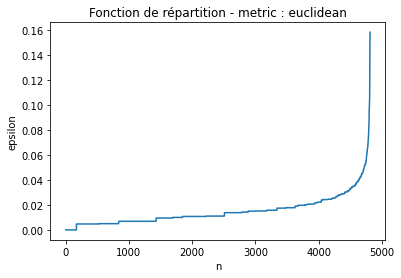

########## METRIC - euclidean - ##############
Distance minimale entre un échantillon et son premier voisin : 0.0 
Distance maximale entre un échantillon et son premier voisin : 0.15816661875132032 
[0.1265333  0.13331186 0.14009043 0.146869   0.15364757 0.16042614
 0.16720471 0.17398328]
silhouette : -0.21379908797641256, calinski : 608.7061238228154, DB : 1.2379934825162118, time : 0.029963970184326172, clusters : 7
silhouette : 0.23339226592744003, calinski : 1821.2023315960819, DB : 2.7813737737766413, time : 0.022576093673706055, clusters : 2
silhouette : 0.22704090300081053, calinski : 1823.0750462496762, DB : 2.161662622814458, time : 0.022453784942626953, clusters : 2
silhouette : 0.22061648272825543, calinski : 1824.310793255261, DB : 1.9653336075030101, time : 0.02313971519470215, clusters : 2
silhouette : 0.22061648272825543, calinski : 1824.310793255261, DB : 1.9653336075030101, time : 0.022738218307495117, clusters : 2
silhouette : -0.21379908797641256, calinski : 608.7061

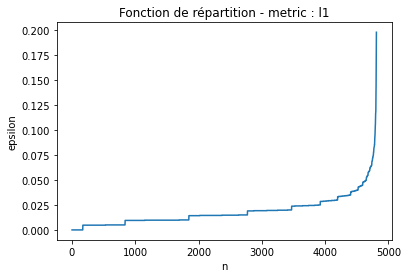

########## METRIC - l1 - ##############
Distance minimale entre un échantillon et son premier voisin : 0.0 
Distance maximale entre un échantillon et son premier voisin : 0.19820115776640154 
[0.15856093 0.16705526 0.1755496  0.18404393 0.19253827 0.2010326
 0.20952694 0.21802127]
silhouette : 0.0025460580127820488, calinski : 911.3271468033516, DB : 1.480655491422645, time : 0.03357291221618652, clusters : 5
silhouette : 0.15290391876122353, calinski : 1822.8021063899769, DB : 1.624590165188841, time : 0.026003599166870117, clusters : 2
silhouette : 0.17202133236200562, calinski : 1825.7018977620771, DB : 1.354910866457538, time : 0.038542747497558594, clusters : 2
silhouette : 0.1733616452805988, calinski : 1827.0350806037259, DB : 1.3162402400969764, time : 0.03642678260803223, clusters : 2
silhouette : 0.1733616452805988, calinski : 1827.0350806037259, DB : 1.3162402400969764, time : 0.026030778884887695, clusters : 2
silhouette : 0.0025460580127820488, calinski : 911.3271468033516

In [ ]:
eval_params, best_params, EPS=bestConfigDBSCAN(path+"banana.arff", params_eps={"n":8, "window_inf":0.8, "window_sup":1.1})

In [ ]:
best_params

In [ ]:
EPS

In [ ]:
doDBSCAN(path+"banana.arff",0.16042614,1,'euclidean')